Importing Libraries

In [1]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
y
y
y
  Successfully uninstalled tensorflow-2.7.0


In [3]:
#!pip install tensorflow
!pip install tensorflow-gpu
!pip install keras-resnet
!pip install h5py pyyaml

     |████████████████████████████████| 489.6 MB 4.7 kB/s 


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

Mounting google drive and datasetpath directory

In [21]:
from google.colab import drive
drive.mount('/content/drive')
trainpath = 'drive/My Drive/ColabDatasets/315_Birds_Species/train'
testpath = 'drive/My Drive/ColabDatasets/315_Birds_Species/test'
validpath = 'drive/My Drive/ColabDatasets/315_Birds_Species/valid'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
def get_image_data(data_path, image_size):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        image_size=image_size,
        label_mode='categorical'
        
    )

In [23]:
TrainDS = get_image_data(trainpath,(224,224))
TestDS = get_image_data(testpath,(224,224))
validDS = get_image_data(validpath,(224,224)) 

Found 46000 files belonging to 315 classes.
Found 1575 files belonging to 315 classes.
Found 1575 files belonging to 315 classes.


In [24]:
for imagebatch, label in TrainDS:  # example is (image, label)
  print(imagebatch.shape, label.shape)
  print(label)
  break

(32, 224, 224, 3) (32, 315)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 315), dtype=float32)


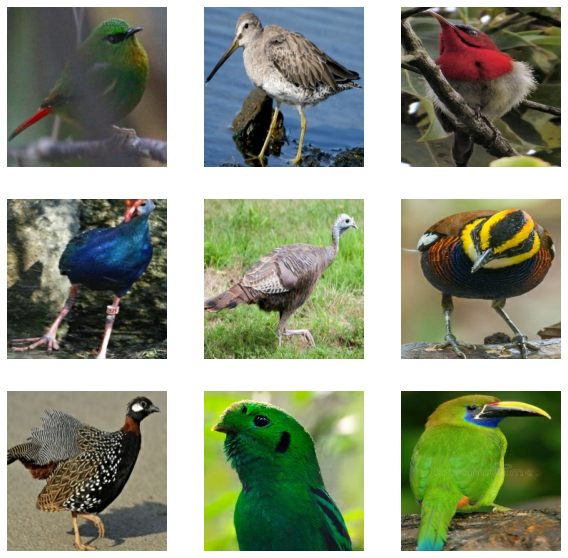

In [25]:

plt.figure(figsize=(10, 10))
for images, labels in TrainDS.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [27]:
normalized_ds = TrainDS.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
test_normalized_ds = TestDS.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
val_normalized_ds = validDS.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


In [28]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading base model resnet

In [29]:
from keras.applications.vgg16 import VGG16
img_height,img_width = 224,224 
num_classes = 315
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))

In [30]:
# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [31]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [32]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
r = transfer_model.fit_generator(train_ds,validation_data=val_ds, epochs=10, callbacks=[lr_reduce,checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
 385/1438 [=======>......................] - ETA: 6:08:06 - loss: 5.7305 - accuracy: 0.0084

In [ ]:
preds = transfer_model.evaluate(test_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
transfer_model.summary()

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
transfer_model.save('BirdVGGnet.h5')

In [ ]:
import tensorflow as tf

new_model = tf.keras.models.load_model('BirdVGGnet.h5') #same file path

In [ ]:
loss, acc = new_model.evaluate(TestImages, Ytest, verbose=0)
print(f"test accuracy {acc*100}")

In [ ]:
new_model.summary()